In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import time


# Девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Створюємо директорії для збереження
os.makedirs('images', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [2]:
device

device(type='cuda')

In [3]:
# Трансформації
transform = transforms.Compose([
    transforms.ToTensor(),                # Перетворення в тензор
    transforms.Normalize([0.5], [0.5])     # Нормалізація до [-1, 1]
])

# Завантаження MNIST
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(mnist, batch_size=128, shuffle=True)

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()   # Виводити дані в діапазоні [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), *self.img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()   # Ймовірність справжнього зображення
        )

    def forward(self, img):
        flat = img.view(img.size(0), -1)
        validity = self.model(flat)
        return validity

In [6]:
# Розміри
noise_dim = 100

# Ініціалізація моделей
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Оптимізатори
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Функція втрат
adversarial_loss = nn.BCELoss()

In [7]:
epochs = 1000
sample_interval = 10
test_z = torch.randn(16, noise_dim, device=device)
start = time.time()

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        batch_size = imgs.size(0)
        
        # Реальні та фейкові мітки
        valid = torch.ones((batch_size, 1), device=device, dtype=torch.float)
        fake = torch.zeros((batch_size, 1), device=device, dtype=torch.float)
        
        real_imgs = imgs.to(device)

        # Навчання Генератора
        optimizer_G.zero_grad()

        # Генеруємо шум
        z = torch.randn(batch_size, noise_dim, device=device)
        
        # Генеруємо зображення
        gen_imgs = generator(z)

        # Хочемо, щоб дискримінатор думав, що це реальні зображення
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()

        # Навчання Дискримінатора
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # Збереження результатів
    if epoch % sample_interval == 0:
        print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        
        # Збереження згенерованих зображень
        with torch.no_grad():
            generated = generator(test_z)
            generated = (generated + 1) / 2  # повертаємо [0,1] для збереження
            save_image(generated, f"images/{epoch}.png", nrow=4, normalize=True)
        
        # Збереження моделей
        torch.save(generator.state_dict(), f"models/generator_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"models/discriminator_{epoch}.pth")
timer = time.time()-start
print ('Time for epochs {} is {} min'.format(epochs, int(timer/60)))


[Epoch 0/1000] [D loss: 0.3691] [G loss: 0.8660]
[Epoch 10/1000] [D loss: 0.4604] [G loss: 1.1791]
[Epoch 20/1000] [D loss: 0.4823] [G loss: 0.9051]
[Epoch 30/1000] [D loss: 0.4405] [G loss: 1.1861]
[Epoch 40/1000] [D loss: 0.4277] [G loss: 1.1031]
[Epoch 50/1000] [D loss: 0.6721] [G loss: 0.5728]
[Epoch 60/1000] [D loss: 0.4991] [G loss: 0.9182]
[Epoch 70/1000] [D loss: 0.5399] [G loss: 1.1779]
[Epoch 80/1000] [D loss: 0.5315] [G loss: 0.9433]
[Epoch 90/1000] [D loss: 0.5123] [G loss: 0.9375]
[Epoch 100/1000] [D loss: 0.5446] [G loss: 1.0312]
[Epoch 110/1000] [D loss: 0.5587] [G loss: 1.0740]
[Epoch 120/1000] [D loss: 0.4287] [G loss: 1.1001]
[Epoch 130/1000] [D loss: 0.5735] [G loss: 1.3294]
[Epoch 140/1000] [D loss: 0.5135] [G loss: 1.0416]
[Epoch 150/1000] [D loss: 0.4947] [G loss: 1.0505]
[Epoch 160/1000] [D loss: 0.3694] [G loss: 1.4190]
[Epoch 170/1000] [D loss: 0.4081] [G loss: 1.2379]
[Epoch 180/1000] [D loss: 0.4167] [G loss: 1.3852]
[Epoch 190/1000] [D loss: 0.5268] [G loss:

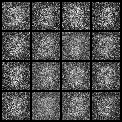

In [8]:
import os
import glob
import imageio
import numpy as np
import IPython.display as display

# Зчитуємо всі збережені картинки
imgs = sorted(
    glob.glob('images/*.png'),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

frames = []

# Кількість проміжних кадрів між 2 основними
transition_frames = 5

for idx in range(len(imgs)-1):
    img1 = imageio.v3.imread(imgs[idx]).astype(np.float32) / 255.0
    img2 = imageio.v3.imread(imgs[idx+1]).astype(np.float32) / 255.0
    
    # Додаємо початковий кадр
    frames.append((img1 * 255).astype(np.uint8))
    
    # Плавні переходи між img1 і img2
    for t in range(1, transition_frames):
        alpha = t / transition_frames
        blended = (1 - alpha) * img1 + alpha * img2
        frames.append((blended * 255).astype(np.uint8))

# Додаємо останній кадр
last_img = imageio.v3.imread(imgs[-1])
frames.append(last_img)

# Зберігаємо фінальний плавний GIF
imageio.mimsave('progress_smooth.gif', frames, duration=0.1)

# Показати в ноутбуці
display.Image(filename='progress_smooth.gif')